In [22]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("Resources/labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
df.shape

(24783, 7)

In [5]:
#define target variable where 1 = hate speech or offensive language, and 0 = neither
df["target"] = df["class"].map({0: 1,
                                 1: 1,
                                 2: 0})
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [6]:
#Text Pre-Processing

In [7]:
#lower case all words before any preprocessing
df["tweet"] = df["tweet"].str.lower()

#removing punctiontions
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '',punctuations_list)
    return text.translate(temp)
df['tweet'] = df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
0,0,3,0,0,3,2,rt mayasolovely as a woman you shouldnt compl...,0
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad for cuff...,1
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life you eve...,1
3,3,3,0,2,1,1,rt cganderson vivabased she look like a tranny,1
4,4,6,0,6,0,1,rt shenikaroberts the shit you hear about me ...,1


In [8]:
#remove words that add no value to the tweet
# https://www.geeksforgeeks.org/hate-speech-detection-using-deep-learning/
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []
    #store the important words
    for word in str(text).split():
        if word not in stop_words:
            #it's recommended to lemmatize the word as well
            #splitting it into its root which will provide a more accurate measure of which words are hate speech
            lemmatizer =WordNetLemmatizer()
            lemmatizer.lemmatize(word)
            imp_words.append(word)
    output = " ".join(imp_words)
    return output
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
0,0,3,0,0,3,2,rt mayasolovely woman shouldnt complain cleani...,0
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...,1
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...,1
3,3,3,0,2,1,1,rt cganderson vivabased look like tranny,1
4,4,6,0,6,0,1,rt shenikaroberts shit hear might true might f...,1


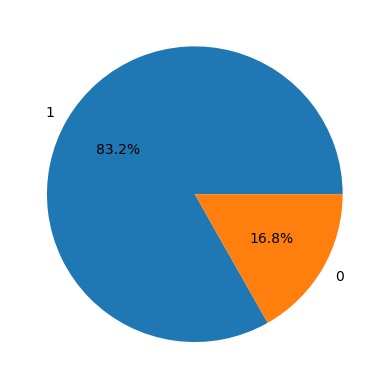

In [9]:
plt.pie(df["target"].value_counts().values,
       labels = df["target"].value_counts().index,
       autopct='%1.1f%%')
plt.show()

In [10]:
## The above graph is very imbalanced, we mmay need to use randomoverampler to get a more balanced
#view of the dataset

In [11]:
y=df["target"]
X=df["tweet"]

In [12]:
X = pd.get_dummies(X)

In [13]:
X.head()

,0 hoes 128588,01takesthelead bitch use whipers,05235fd083ad408 hick yes,05professor bet hes starbucks queer,05professor charlie sheen could coach better crusty dusty yeah hired bryan price pitching coach,05professor thats happens getting pussy pussy twitter seems like clear cut choice hahahaha,0beythelau huntermoore bitch gross fuck touchin saggy titties,0ddment could fuck bowl graham cracker cereal,0hallis0n bitch caught body week ago everybody catching bullet holes,0o faggot,...,zooyorkinit youre frumpy bitch,zp3 little girl tom sawyer gets trapped cave along injun joe almost die injun joe dies find treasure,zramsin betodavidthomas go fuck self pussy 128536,zrexxx slowdollaz take bitch recieve head mom,zt0mm lucky monkey,ztsupreme uncr4fted yopapichulo doesnt matter joke fact still remains hes faggot pretending girl,zuko gets bitches,zwaaad fag,zwengersierra bitch,zzzentropy guynamedjordan bitch boys
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
#convert to integer from boolean
X = X*1

In [15]:
X.head()

,0 hoes 128588,01takesthelead bitch use whipers,05235fd083ad408 hick yes,05professor bet hes starbucks queer,05professor charlie sheen could coach better crusty dusty yeah hired bryan price pitching coach,05professor thats happens getting pussy pussy twitter seems like clear cut choice hahahaha,0beythelau huntermoore bitch gross fuck touchin saggy titties,0ddment could fuck bowl graham cracker cereal,0hallis0n bitch caught body week ago everybody catching bullet holes,0o faggot,...,zooyorkinit youre frumpy bitch,zp3 little girl tom sawyer gets trapped cave along injun joe almost die injun joe dies find treasure,zramsin betodavidthomas go fuck self pussy 128536,zrexxx slowdollaz take bitch recieve head mom,zt0mm lucky monkey,ztsupreme uncr4fted yopapichulo doesnt matter joke fact still remains hes faggot pretending girl,zuko gets bitches,zwaaad fag,zwengersierra bitch,zzzentropy guynamedjordan bitch boys
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 1)

In [23]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=2)

In [25]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

In [26]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)


In [27]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           1       1.00      0.84      0.91      6195

    accuracy                           0.84      6196
   macro avg       0.50      0.92      0.46      6196
weighted avg       1.00      0.84      0.91      6196



In [32]:
# Define the deep learning model 

nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu', input_dim=24699)) 
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50


581/581 [==============================] - 3s 4ms/step - loss: 0.4849 - accuracy: 0.8193
Epoch 2/50
581/581 [==============================] - 2s 3ms/step - loss: 0.2379 - accuracy: 0.8971
Epoch 3/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0588 - accuracy: 0.9810
Epoch 4/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0175 - accuracy: 0.9960
Epoch 5/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0104 - accuracy: 0.9973
Epoch 6/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0073 - accuracy: 0.9978
Epoch 7/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0063 - accuracy: 0.9979
Epoch 8/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0058 - accuracy: 0.9979
Epoch 9/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.9980
Epoch 10/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0051 - accuracy: 0.99

In [33]:
!pip install keras-tuner

In [38]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    
    #allow kerastuner to decide the activation funcitons for hidden layers
    activation = hp.Choice('activation', ['relu','tanh','sigmoid'])
    
    #allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
            min_value = 1,
            max_value = 50,
            step =5), activation = activation, input_dim=24699))
    #allow kerastuner to decide number of hidden layers and neurons in the layers
    for i in range(hp.Int('num_layers',1,6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' +str(i),
            min_value = 1,
            max_value = 50,
            step=5), activation = activation))
    nn_model.add(tf.keras.layers.Dense(units=1, activation = "sigmoid"))
    
    #compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [39]:
#import & create kerastuner setup
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective = 'val_accuracy',
    max_epochs = 20,
    hyperband_iterations =2)

Reloading Tuner from .\untitled_project\tuner0.json


In [40]:
#run the kerastuner search for the best parameters
tuner.search(X_train_scaled, y_train, epochs =20, validation_data = (X_test_scaled, y_test))

Trial 60 Complete [00h 01m 06s]
val_accuracy: 0.8373143672943115

Best val_accuracy So Far: 0.8374757766723633
Total elapsed time: 00h 35m 32s


In [41]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 5,
 'num_layers': 3,
 'units_0': 5,
 'units_1': 9,
 'units_2': 1,
 'units_3': 5,
 'units_4': 5,
 'units_5': 1,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [42]:
#evaluate best model against the full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

194/194 - 0s - loss: 0.4443 - accuracy: 0.8375 - 453ms/epoch - 2ms/step
Loss: 0.4442571699619293, Accuracy: 0.8374757766723633


In [43]:
#attempt to normalize the data to enhance model performance
from sklearn.preprocessing import normalize

X_train_normalized = normalize(X_train, axis=0)
X_test_normalized = normalize(X_test, axis=0)

In [44]:
#generate a model using normalized data

nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu', input_dim=24699)) 
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_normalized,y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_normalized,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
581/581 [==============================] - 3s 4ms/step - loss: 0.4737 - accuracy: 0.8300
Epoch 2/50
581/581 [==============================] - 2s 3ms/step - loss: 0.3590 - accuracy: 0.8354
Epoch 3/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0240 - accuracy: 0.9999
Epoch 4/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 5/50
581/581 [==============================] - 2s 4ms/step - loss: 7.1995e-04 - accuracy: 0.9999
Epoch 6/50
581/581 [==============================] - 2s 4ms/step - loss: 4.9391e-04 - accuracy: 0.9999
Epoch 7/50
581/581 [==============================] - 2s 4ms/step - loss: 3.7651e-04 - accuracy: 0.9999
Epoch 8/50
581/581 [==============================] - 2s 4ms/step - loss: 3.2420e-04 - accuracy: 0.9999
Epoch 9/50
581/581 [==============================] - 2s 4ms/step - loss: 2.7407e-04 - accuracy: 0.9999
Epoch 10/50
581/581 [==============================] - 2s 4ms/step - loss: 2.427

In [46]:
#use dropout regularization to prevent overfitting
nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu', input_dim=24699)) 
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu'))
nn_model.add(tf.keras.layers.Dropout(0.5))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
581/581 [==============================] - 3s 4ms/step - loss: 0.5236 - accuracy: 0.8046
Epoch 2/50
581/581 [==============================] - 2s 4ms/step - loss: 0.4198 - accuracy: 0.8288
Epoch 3/50
581/581 [==============================] - 2s 4ms/step - loss: 0.2700 - accuracy: 0.8411
Epoch 4/50
581/581 [==============================] - 2s 4ms/step - loss: 0.1372 - accuracy: 0.9440
Epoch 5/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0788 - accuracy: 0.9804
Epoch 6/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0541 - accuracy: 0.9879
Epoch 7/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0329 - accuracy: 0.9924
Epoch 8/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0247 - accuracy: 0.9951
Epoch 9/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0191 - accuracy: 0.9969
Epoch 10/50
581/581 [==============================] - 2s 4ms/step - loss: 0.0145 - accuracy: 0.9978